In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import utils_img_rec as ut

import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers, models, utils

import pickle
inicio = time.time()

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.0
GPU is available


2022-06-26 19:34:58.949292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 19:34:58.962090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 19:34:58.962385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Definindo Variaveis

In [2]:
BATCH_SIZE = 5000
EPOCHS = 150
IMG_SIZE = 32
numero_de_canais = 3
teste_treino = True
patience = 10
save_model = True

DATA_DIR = '../_DATA_/image/pickle/cifar10-train-pickle.pickle'

TEST_DIR = '../_DATA_/image/pickle/cifar10-test-pickle.pickle'

caminho_modelo = '../modelos_salvos/tensorflow/'
nome = 'modelo_cifar10'+'-EPOCHS='+str(EPOCHS)

DATA_DIR = pathlib.Path(DATA_DIR)
TEST_DIR = pathlib.Path(TEST_DIR)

## Lendo e preparando os dados

In [3]:
pickle_in = open(DATA_DIR,"rb")
data_train = pickle.load(pickle_in)

In [4]:
if teste_treino:
    pickle_in = open(TEST_DIR,"rb")
    data_test = pickle.load(pickle_in)

In [5]:
CATEGORIES = ut.get_classes(data_train)
CATEGORIES.sort()
try:
    CATEGORIES.remove('.ipynb_checkpoints')
except:
    pass
print(CATEGORIES)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
train_X, train_y = ut.prep_data(data_train, CATEGORIES, IMG_SIZE, numero_de_canais)
#print("Number of training images: ",len(data_train))
print('Entradas de treino - {} - ({}x{})'.format( train_X.shape[0], train_X.shape[1], train_X.shape[2] ))

Entradas de treino - 50000 - (32x32)


## Exibindo amostra dos dados de treino

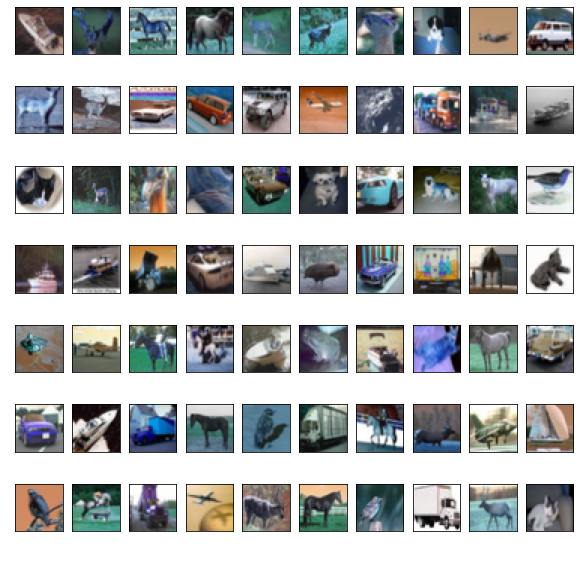

In [7]:
plt.figure(figsize=(10,10))
m = 70
if( len(data_train) < 70 ):
    m = len(data_train)
for i in range(m):
    plt.subplot(7,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_train[i][0], cmap='gray')
    plt.xlabel("{}\n({})".format( data_train[i][1] , data_train[i][2] ), color='white')    
plt.show()

In [8]:
if teste_treino:
    test_X, test_y = ut.prep_data(data_test, CATEGORIES, IMG_SIZE, numero_de_canais)
    #print("Number of test images: ",len(data_test))
    print('Entradas de teste - {} - ({}x{})'.format( test_X.shape[0], test_X.shape[1], test_X.shape[2] ))

Entradas de teste - 10000 - (32x32)


## Exibindo amostra dos dados de teste

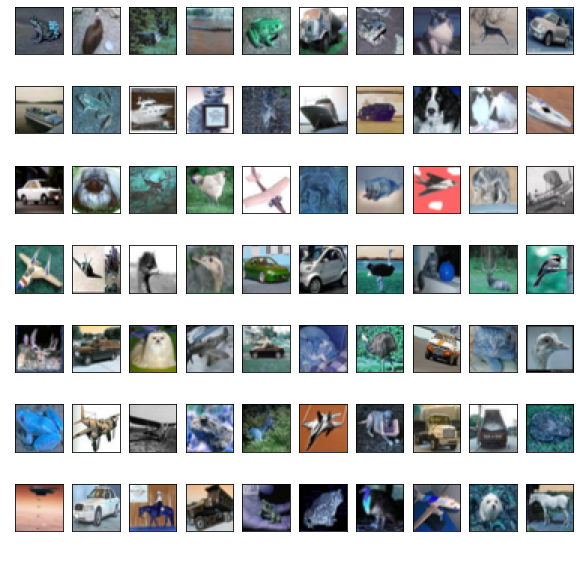

In [9]:
plt.figure(figsize=(10,10))
m = 70
if( len(data_test) < 70 ):
    m = len(data_test)
for i in range(m):
    plt.subplot(7,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_test[i][0], cmap='gray')
    plt.xlabel("{}\n({})".format( data_test[i][1] , data_test[i][2] ), color='white')    
plt.show()

## Normalizando dados

In [10]:
train_X=np.array(train_X/255.0)
train_y=np.array(train_y)
if teste_treino:
    test_X=np.array(test_X/255.0)
    test_y=np.array(test_y)

## Modelo

In [11]:
model = models.Sequential()
model.add( layers.Conv2D(filters=16, kernel_size=(7, 7), activation='relu', input_shape=(test_X.shape[1:])))
model.add( layers.MaxPooling2D((2, 2)))

model.add( layers.Dropout(rate=0.2) )

#model.add( layers.Conv2D(filters=16, kernel_size=(4, 4), activation='relu'))
#model.add( layers.MaxPooling2D((2, 2)))

#model.add( layers.Dropout(rate=0.2) )

#model.add( layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
#model.add( layers.MaxPooling2D((2, 2)))

#model.add( layers.Dropout(rate=0.2) )

model.add( layers.Flatten( ) )
#model.add( layers.Dense(6000, activation='relu') )
#model.add( layers.Dropout(rate=0.3) )

model.add( layers.Dense(1024, activation='relu') )
model.add( layers.Dropout(rate=0.25) )

model.add( layers.Dense(128, activation='relu') )
model.add( layers.Dense(len(CATEGORIES) , activation='softmax') )

2022-06-26 19:35:10.220707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 19:35:10.221050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 19:35:10.221306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 19:35:11.101007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 19:35:11.101318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

## Realizando o treino

In [12]:
#opt = tf.keras.optimizers.SGD(
#    learning_rate=0.01, momentum=0.1, nesterov=False, name="SGD")
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True, verbose=0)

if  teste_treino:
    history = model.fit(train_X, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_X, test_y), callbacks=[earlystopper])
else:
    history = model.fit(train_X, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[earlystopper])

Epoch 1/150


2022-06-26 19:35:14.800581: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2022-06-26 19:35:15.559567: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-06-26 19:35:15.653436: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.87GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 1/10 [==>...........................] - ETA: 28s - loss: 2.3552 - accuracy: 0.0998

2022-06-26 19:35:15.968888: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1010.87MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


10/10 [==============================] - 5s 203ms/step - loss: 2.2466 - accuracy: 0.1790 - val_loss: 2.0017 - val_accuracy: 0.2926
Epoch 2/150
10/10 [==============================] - 1s 134ms/step - loss: 1.9142 - accuracy: 0.3100 - val_loss: 1.7785 - val_accuracy: 0.3782
Epoch 3/150
10/10 [==============================] - 1s 135ms/step - loss: 1.7397 - accuracy: 0.3776 - val_loss: 1.6356 - val_accuracy: 0.4215
Epoch 4/150
10/10 [==============================] - 1s 135ms/step - loss: 1.6262 - accuracy: 0.4202 - val_loss: 1.5456 - val_accuracy: 0.4493
Epoch 5/150
10/10 [==============================] - 1s 135ms/step - loss: 1.5500 - accuracy: 0.4465 - val_loss: 1.5007 - val_accuracy: 0.4603
Epoch 6/150
10/10 [==============================] - 1s 135ms/step - loss: 1.4980 - accuracy: 0.4646 - val_loss: 1.4601 - val_accuracy: 0.4764
Epoch 7/150
10/10 [==============================] - 1s 135ms/step - loss: 1.4580 - accuracy: 0.4811 - val_loss: 1.3988 - val_accuracy: 0.5013
Epoch 8/150

## Grafico do treino

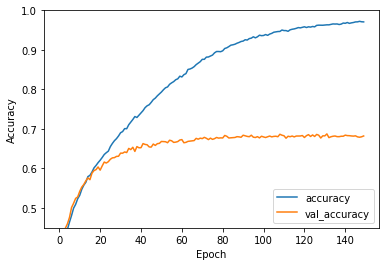

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.45, 1])
plt.legend(loc='lower right')

In [14]:
print('Tempo de execução: ', time.time() - inicio)

Tempo de execução:  218.48091101646423


In [15]:
if save_model:
    loss, acc = model.evaluate(np.concatenate((train_X, test_X)), np.concatenate((train_y, test_y)), verbose=1)
    nome_saida = caminho_modelo+nome+' - acc = '+   str(round(acc, 5))  + ' exec_time - '+ str( round(time.time() - inicio, 4) )  + '.h5'
    model.save(nome_saida)
    print('Salvo como: ',nome_saida)

1875/1875 [==============================] - 9s 5ms/step - loss: 0.2354 - accuracy: 0.9469
Salvo como:  ../modelos_salvos/tensorflow/modelo_cifar10-EPOCHS=150 - acc = 0.94693 exec_time - t-train230.0471.h5
